250000
filter the chain to cut off possibly unnecessary bits
150000
lower bound log likelihood 1.4863644252658663
chain means: [[2.63381968 2.90569753]]
chain covariances: [[[0.01206028 0.00238228]
  [0.00238228 0.01501583]]]
gaussian weights: [1.]
lower bound log likelihood 1.4883552247678742
chain means: [[2.59263002 2.83013338]
 [2.6721171  2.97595576]]
chain covariances: [[[ 1.10633350e-02 -1.01429585e-03]
  [-1.01429585e-03  1.10263039e-02]]

 [[ 9.94306583e-03 -4.42622197e-05]
  [-4.42622197e-05  8.47999794e-03]]]
gaussian weights: [0.48180691 0.51819309]
lower bound log likelihood 1.4880659911466354
chain means: [[2.61581521 2.79759889]
 [2.56389066 2.94599817]
 [2.70504541 2.9737817 ]]
chain covariances: [[[0.01106596 0.00114693]
  [0.00114693 0.00903855]]

 [[0.00786887 0.00071963]
  [0.00071963 0.00834344]]

 [[0.00705856 0.00037932]
  [0.00037932 0.00906706]]]
gaussian weights: [0.34084558 0.28912958 0.37002484]


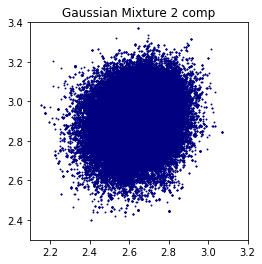

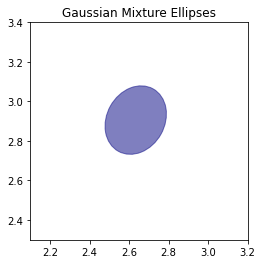

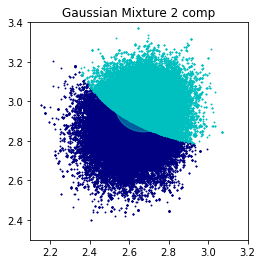

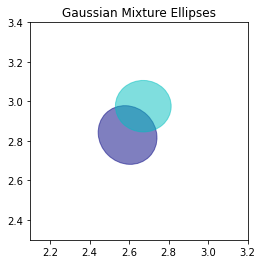

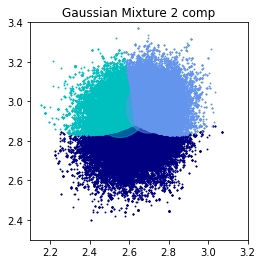

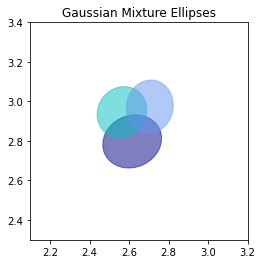

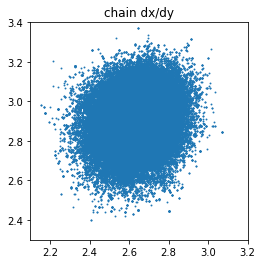

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from scipy import linalg
import itertools
import matplotlib as mpl

# plot_results and plot_ellipse code from Scikit-learn: Machine Learning in 
# Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
# URL: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html

def gaus_mix_mod(chain_dy, chain_dx, chain_llhoods, chain_dmags, chain_mod_llhoods):
    print(len(chain_dx))
    print("filter the chain to cut off possibly unnecessary bits")
    chain_dy = chain_dy[100000:]
    chain_dx = chain_dx[100000:]
    print(len(chain_dx))
    
    chain_dxdy = np.column_stack((chain_dy,chain_dx))
    
    call_gaus(chain_dxdy, 1)
    call_gaus(chain_dxdy, 2)
    call_gaus(chain_dxdy, 3)
    #call_dirichlet(chain_dxdy, 2)
    #call_dirichlet(chain_dxdy, 3)
    
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    plt.scatter(chain_dy, chain_dx, 0.8,)
    plt.xlim(2.1, 3.2)
    plt.ylim(2.3, 3.4)
    plt.title("chain dx/dy")
    plt.show()
    
def call_gaus(chain_dxdy, comp):
    GMM = GaussianMixture(n_components=comp, covariance_type="full").fit(chain_dxdy)
    print("lower bound log likelihood", GMM.lower_bound_)
    print("chain means:", GMM.means_)
    print("chain covariances:", GMM.covariances_)
    print("gaussian weights:", GMM.weights_)
    #print("\n",GMM.predict([[2.6, 3], [2.8, 2.8]]))
    plot_results(chain_dxdy, GMM.predict(chain_dxdy), GMM.means_, GMM.covariances_, 0, "Gaussian Mixture 2 comp")
    plot_ellipse(chain_dxdy, GMM.predict(chain_dxdy), GMM.means_, GMM.covariances_, 0, "Gaussian Mixture Ellipses")

def call_dirichlet(chain_dxdy, comp):
    dpgmm = BayesianGaussianMixture(n_components=comp, covariance_type="full").fit(chain_dxdy)
    print("applied Bayesian model")
    print("chain means:", dpgmm.means_)
    print("chain covariances:", dpgmm.covariances_)
    print("gaussian weights:", dpgmm.weights_)
    plot_results(chain_dxdy, dpgmm.predict(chain_dxdy), dpgmm.means_, dpgmm.covariances_, 1, "Bayesian Gaussian Mixture with a Dirichlet process prior",)
    plot_ellipse(chain_dxdy, dpgmm.predict(chain_dxdy), dpgmm.means_, dpgmm.covariances_, 1, "ellipses Dirichlet",)
    
def plot_results(X, Y_, means, covariances, index, title):
    color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])
    #splot = plt.subplot(1, 2, 1 + index)
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component    
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        #splot.add_artist(ell)
        ax.add_artist(ell)

    plt.xlim(2.1, 3.2)
    plt.ylim(2.3, 3.4)
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)
    
def plot_ellipse(X, Y_, means, covariances, index, title):
    color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])
    #splot = plt.subplot(1, 2, 1 + index)
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        #plt.scatter(X.max(), 0.8, color=color, alpha=0.1)

        # Plot an ellipse to show the Gaussian component    
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        #splot.add_artist(ell)
        ax.add_artist(ell)

    plt.xlim(2.1, 3.2)
    plt.ylim(2.3, 3.4)
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)

def import_chain():
    chain_dy = np.load("chain_dy.npy")
    chain_dx = np.load("chain_dx.npy")
    chain_llhoods = np.load("chain_llhoods.npy")
    chain_dmags = np.load("chain_dmags.npy")
    chain_mod_llhoods = np.load("chain_mod_llhoods.npy")

    chain_arr = chain_dy, chain_dx, chain_llhoods, chain_dmags, chain_mod_llhoods
    return chain_arr

chain_arr = import_chain()
chain_dy = chain_arr[0]
chain_dx = chain_arr[1]
chain_llhoods = chain_arr[2]
chain_dmags = chain_arr[3]
chain_mod_llhoods = chain_arr[4]
gaus_mix_mod(chain_dy, chain_dx, chain_llhoods, chain_dmags, chain_mod_llhoods)